<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G-2.0/blob/master/workshops/hyperparameters/hyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameters


## Goals

The goal of this workshop is to become more familiar with:
- the concept of hyperparameters
- the usual hyperparameters for a neural network
- the basics of what it looks like to develop machine learning models
- what can make the difference between successful and unsuccessful training

## Structure of the notebook
- Generating toy data
- Creating the neural network
- Writing the training loop
- Evaluating the model
- Searching for good hyperparameters
  - Impact of the optimizer
  - Impact of the architecture of the model
  - Impact of the loss function
- Evaluating the model on a test set

## Hyperparameters

*OPTIONAL: The text before the next code block is optional reading and recaps what was already explained in the session introduction.*

In the prerequisites you trained a model to learn the sine function. In the process, we implicitly made many decisions, such as to use a degree 3 polynomial, to use a specific learning rate, etc.

The learning rate is an example of a **hyperparameter**. A regular parameter is a variable whose value is optimized during the training process. (And because we are using gradient descent for optimization, we must be able to differentiate the loss with respect to the parameters.) The learning rate, in contrast, is not typically determined by this training process. (We cannot differentiate the loss with respect to the learning rate — in this case since the learning rate is something that shows up in the definition of gradient descent itself.)

One way we might tune hyperparameters is to introduce an outer loop (that wraps around the training loop) to search for good hyperparameter values. This outer loop is called a hyperparameter search. Obtaining results for each combination of hyperparameters requires running the full inner training loop and then checking how well the model does on a held-out validation dataset (which should be different from the test dataset you use to see how good your final model is).

Since every iteration of a hyperparameter search involves a training run (each of which might be very expensive), we often do not hope to find an optimum but rather to improve upon our initial guesses enough to justify the cost of the search.

In addition, though some hyperparameters are continuous, like the learning rate, they can also be discrete, like the number of layers in the network, type of loss function, type of optimization algorithm, type of learning rate scheduler, and so on.

More broadly, every design decision for the training process can be considered a hyperparameter, including how to preprocess the input data, the connectivity of different layers, and so on. What exactly people mean by the hyperparameters depends on the context.

In [11]:
import matplotlib.pyplot as plt
import torch

## Generating toy data

In [12]:
# We define a function to generate our synthetic the dataset, in the form of two interlaced spirals.
# You don't need to understand this code, just run it.


def spiral(phi):
    x = (phi + 1) * torch.cos(phi)
    y = phi * torch.sin(phi)
    return torch.cat((x, y), dim=1)


def generate_data(num_data):
    angles = torch.empty((num_data, 1)).uniform_(1, 15)
    data = spiral(angles)
    # Add some noise to the data.
    data += torch.empty((num_data, 2)).normal_(0.0, 0.4)
    labels = torch.zeros((num_data,), dtype=torch.int)
    # Flip half of the points to create two classes.
    data[num_data // 2 :, :] *= -1
    labels[num_data // 2 :] = 1
    return data, labels

In [13]:
# Generate a training set with 4000 examples.

x_train, y_train = generate_data(4000)

print("x_train shape:", x_train.size())
print("y_train shape:", y_train.size())

x_train shape: torch.Size([4000, 2])
y_train shape: torch.Size([4000])


In [14]:
# You don't need to understand this code, just run it.
def plot_data(x, y):
    """Plot data points x with labels y. Label 1 is a red +, label 0 is a blue +."""
    plt.figure(figsize=(5, 5))
    plt.plot(x[y == 1, 0], x[y == 1, 1], "r+")
    plt.plot(x[y == 0, 0], x[y == 0, 1], "b+")

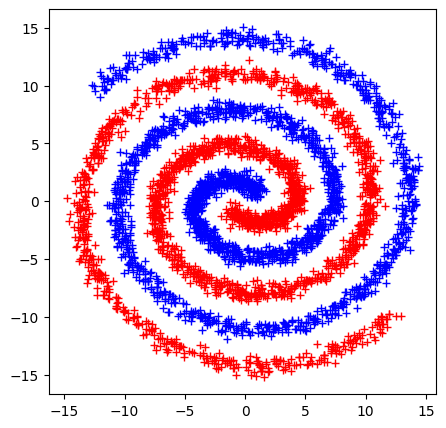

In [15]:
# Visualize the data.
plot_data(x_train, y_train)

As seen in the pre-requisite materials, PyTorch has `Dataset` and `DataLoader` objects, which make it convenient to load the data in batches, shuffle the data, etc.

In [16]:
from torch.utils.data import TensorDataset, DataLoader

training_set = TensorDataset(x_train, y_train)

##  Creating the neural network

Here we create the neural network. This is the model you'll try to improve in the exercises.

It is already created for you, but you should read through the code and understand what is done on each line.

In [17]:
import torch.nn as nn
from typing import Literal

A tutorial for constructing models can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [18]:
# Read this code line-by-line.


class Model(nn.Module):
    """
    A fully connected neural network with any number of layers.
    """

    NAME_TO_NONLINEARITY = {
        "relu": nn.ReLU,
        "sigmoid": nn.Sigmoid,
        "tanh": nn.Tanh,
    }

    def __init__(
        self,
        layer_sizes: list[int] = [2, 10, 1],
        non_linearity: Literal["relu", "sigmoid", "tanh"] = "relu"
    ):
        super(Model, self).__init__()

        modules = []
        for input_dim, output_dim in zip(layer_sizes[:-1], layer_sizes[1:]):
            modules.append(nn.Linear(input_dim, output_dim))
            # After each linear layer, apply a non-linearity.
            modules.append(self.NAME_TO_NONLINEARITY[non_linearity]())

        # Remove the last non-linearity, since the last layer is the output layer.
        self.layers = nn.Sequential(*modules[:-1])

    def forward(self, inputs):
        outputs = self.layers(inputs)
        # We want the model to predict 0 for one class and 1 for the other class.
        # A sigmoid function maps the output from [-inf, inf] to [0, 1].
        prediction = torch.sigmoid(outputs)
        return prediction

In [19]:
# Create the model.
model = Model()

# Choose the hyperparameters for the training loop.
num_epochs = 10
batch_size = 16

# Choose the loss function. This one is a mean squared error (MSE) loss, where the
# error refers to the difference between the output of the network and the target label.
loss_function = nn.MSELoss()

# Choose the optimizer. We use a stochastic gradient descent (SGD) optimizer
# with a learning rate (lr) of 0.01.
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Writing the training loop
More information can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) if needed.

In [20]:
# Read this code line-by-line.
# It's code you want to understand because it is central to ML.

# tqdm is a library used to display progress bars. It's useful when training.
from tqdm.notebook import tqdm


def train(
    num_epochs: int,
    batch_size: int,
    loss_function: nn.Module,
    optimizer: torch.optim.Optimizer,
    model: nn.Module,
    dataset: torch.utils.data.Dataset,
    verbose: bool = False
):
    """Train a model."""
    # Initialize a list to store the training losses.
    train_losses = []
    # Create a DataLoader to iterate over the dataset in batches.
    train_loader = DataLoader(dataset, batch_size, shuffle=True)

    for epoch in tqdm(range(num_epochs)):
        epoch_average_loss = 0
        # Each epoch, we iterate over the dataset once.
        for x_batch, y_true in train_loader:
            # Compute the predictions.
            # Output shape is (batch_size, 1), so we squeeze the last dimension.
            y_predicted = model(x_batch).squeeze(1)

            # The loss is how far the predictions are from the true labels
            loss = loss_function(y_predicted, y_true.float())

            # Do gradient descent to minimize the loss.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Record the average loss for this batch.
            epoch_average_loss += loss.item() * batch_size / len(dataset)

        train_losses.append(epoch_average_loss)

        if verbose:
            print(f"Epoch [{epoch + 1} / {num_epochs}], Loss: {epoch_average_loss:.4f}")

    return train_losses

In [28]:
# Run the training loop.
train_losses = train(num_epochs, batch_size, loss_function, optimizer, model, training_set, 1)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1 / 10], Loss: 0.2798
Epoch [2 / 10], Loss: 0.2798
Epoch [3 / 10], Loss: 0.2798
Epoch [4 / 10], Loss: 0.2798
Epoch [5 / 10], Loss: 0.2798
Epoch [6 / 10], Loss: 0.2798
Epoch [7 / 10], Loss: 0.2798
Epoch [8 / 10], Loss: 0.2798
Epoch [9 / 10], Loss: 0.2798
Epoch [10 / 10], Loss: 0.2798


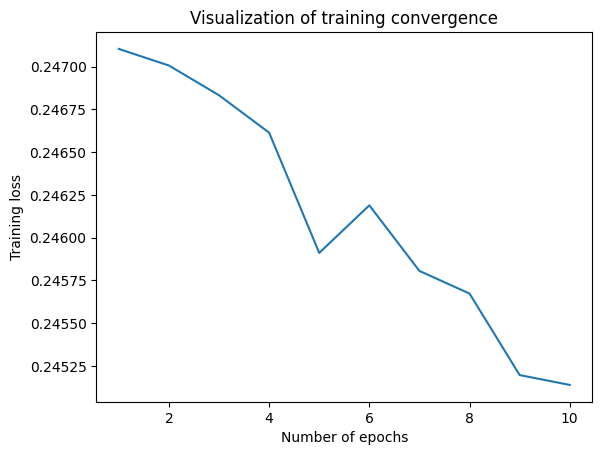

In [22]:
# Plot the training error w.r.t. the number of epochs.
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.title("Visualization of training convergence")
plt.show()

## Evaluating the model

We now evaluate the accuracy on a validation set, to see how the model performs on data it did not see during training.

In [47]:
# Read this code line-by-line.
# It's code you want to understand as it is central to ML.

# Generate 1000 validation datapoints.
x_val, y_val = generate_data(1000)


def get_accuracy(model, x=x_val, y=y_val):
    """Compute the accuracy of the model on a dataset."""
    # Compute the predictions without keeping track of the gradients.
    with torch.inference_mode():
        y_predicted = model(x).squeeze(1)

    # The predictions are in [0, 1] and the labels are either 0 or 1.
    # So we round the predictions to get the predicted labels.
    y_predicted = torch.round(y_predicted)

    # Compute the accuracy by counting the number of correct predictions.
    accuracy = (y_predicted == y).sum().item() / len(y)

    return accuracy

In [50]:
print(f"Accuracy on {len(y_val)} examples: {get_accuracy(model):.2%}")

Accuracy on 1000 examples: 55.30%


Then we visualize what the model has learned by plotting all the predictions.

In [35]:
# You don't need to understand this code, just run it.


def compare_predictions(model, x=x_val, y=y_val):
    """Compare the prediction with real labels."""

    with torch.inference_mode():
        y_predicted = model(x).squeeze(1)

    plt.figure(figsize=(10, 5))

    reds = y > 0.5
    plt.subplot(121)
    plt.plot(x[reds, 0], x[reds, 1], "r+")
    plt.plot(x[~reds, 0], x[~reds, 1], "b+")
    plt.title("real data")

    reds = y_predicted > 0.5
    plt.subplot(122)
    plt.plot(x[reds, 0], x[reds, 1], "r+")
    plt.plot(x[~reds, 0], x[~reds, 1], "b+")
    plt.title("predicted data")

    plt.show()

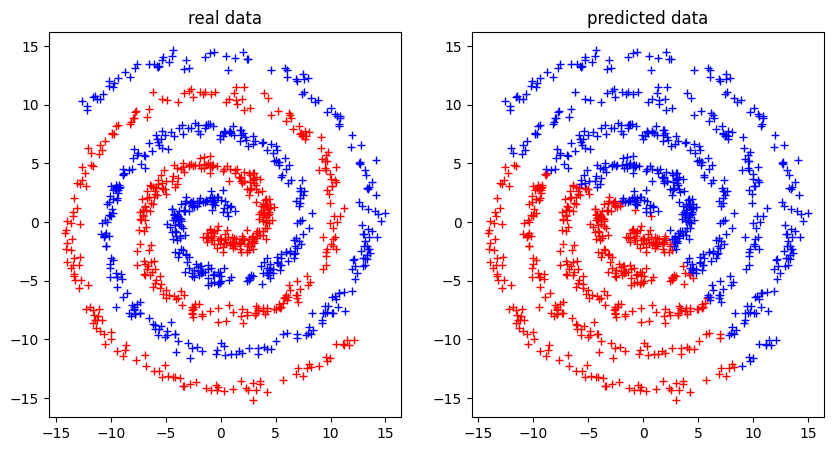

In [26]:
compare_predictions(model)

## Searching for good hyperparameters

We will now try to find the best combination of hyperparameters.

*RECOMMENDATION: For this exercise to be maximally useful, you can make predictions about each experiment before running the code. Write down your predictions somewhere and check your predictions against what is observed.*

Bonus:
- If you want, you can make your predictions on [FateBook](https://fatebook.io), a nice website to easily make predictions, resolve them, and see your calibration.
- Organize the results of the experiments in a clean way, so that a nice visualization would be produced if you reset the notebook and clicked 'Run All'.

You have a few options for Exercise 1 and 2 below:

1. Loop over different hyperparameter combinations and make plots that illustrate the effect of each hyperparameter [on the validation performance] while keeping the others fixed. You could also make some two-dimensional plots that illustrate the joint effect of two hyperparameters at a time.

2. If short on time, or if you do not care about being too systematic or getting an initial feel for what things look like at the level of Python code, you can also use the [Neural Network Playground](https://playground.tensorflow.org#dataset=spiral) to more visually and informally experiment with hyperparameters as described below. The neural network architecture and the spiral dataset in the playground are similar to the setup in this notebook.

3. If you are comfortable coding and feel like learning how to use a popular "MLOps" framework, you can also follow a tutorial like [this one from Weights & Biases](https://docs.wandb.ai/tutorials/sweeps/) and try to use their framework to search for hyperparameters here.

### Exercise 1: Impact of the optimizer

Retrain the model by using different hyperparameters. You can change them in the definitions in previous cells, but it is recommended that you put the code for modifying the values of hyperparameters in the cell below.

Try to see the impact of the following factors:
* Use different batch sizes from 16 to 1024.
* Use different values of the learning rate (for example, between 0.001 and 10), and see how these impact the training process.
* Change the duration of the training by increasing the number of epochs.
* Use other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop).

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1 / 10], Loss: 0.2523
Epoch [2 / 10], Loss: 0.2515
Epoch [3 / 10], Loss: 0.2511
Epoch [4 / 10], Loss: 0.2508
Epoch [5 / 10], Loss: 0.2506
Epoch [6 / 10], Loss: 0.2504
Epoch [7 / 10], Loss: 0.2503
Epoch [8 / 10], Loss: 0.2502
Epoch [9 / 10], Loss: 0.2501
Epoch [10 / 10], Loss: 0.2501


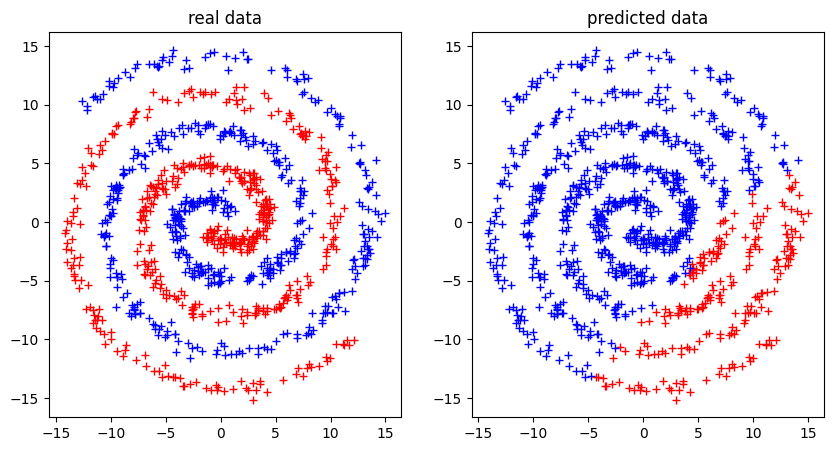

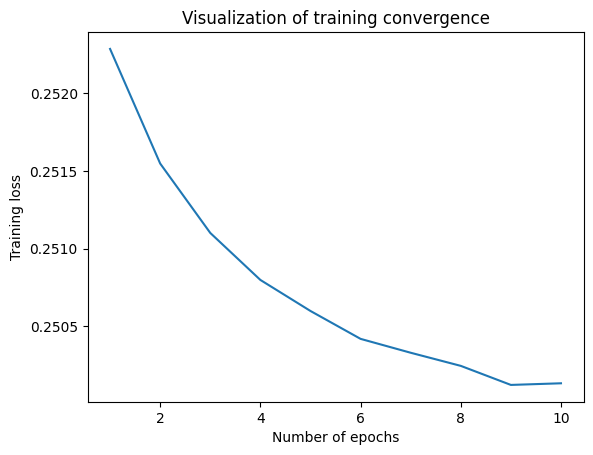

Accuracy on 1000 examples: 49.70%


In [59]:
# Create the model.
model = Model()

# Choose the hyperparameters for the training loop.
num_epochs = 10
batch_size = 16


# Choose the loss function. This one is a mean squared error (MSE) loss, where the
# error refers to the difference between the output of the network and the target label.
loss_function = nn.MSELoss()

# Choose the optimizer. We use a stochastic gradient descent (SGD) optimizer
# with a learning rate (lr) of 0.01.
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


# Run the training loop.
train_losses = train(num_epochs, batch_size, loss_function, optimizer, model, training_set, 1)

#compare predictions
compare_predictions(model)

# Plot the training error w.r.t. the number of epochs.
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.title("Visualization of training convergence")
plt.show()

#accuracy check with diff HPs
print(f"Accuracy on {len(y_val)} examples: {get_accuracy(model):.2%}")


### Exercise 2: Impact of the architecture of the model

Try to see the impact of the following factors:

* Try to add more layers.
* Try to change the number of neurons in each layer.
* Try different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [ReLU](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), and so on).

These changes may interact with your previous choices of hyperparameters!

You can thus also try to explore questions like:
* Do all network architectures react the same way to different learning rates?

In [69]:

class Model(nn.Module):
    """
    A fully connected neural network with any number of layers.
    """

    NAME_TO_NONLINEARITY = {
        "relu": nn.ReLU,
        "sigmoid": nn.Sigmoid,
        "tanh": nn.Tanh,
    }

    def __init__(
        self,
        layer_sizes: list[int] = [2, 20, 30, 50, 1],
        non_linearity: Literal["relu", "sigmoid", "tanh"] = "relu"
    ):
        super(Model, self).__init__()

        modules = []
        for input_dim, output_dim in zip(layer_sizes[:-1], layer_sizes[1:]):
            modules.append(nn.Linear(input_dim, output_dim))
            # After each linear layer, apply a non-linearity.
            modules.append(self.NAME_TO_NONLINEARITY[non_linearity]())

        # Remove the last non-linearity, since the last layer is the output layer.
        self.layers = nn.Sequential(*modules[:-1])

    def forward(self, inputs):
        outputs = self.layers(inputs)
        # We want the model to predict 0 for one class and 1 for the other class.
        # A sigmoid function maps the output from [-inf, inf] to [0, 1].
        prediction = torch.sigmoid(outputs)
        return prediction


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1 / 10], Loss: 0.2357
Epoch [2 / 10], Loss: 0.1819
Epoch [3 / 10], Loss: 0.1194
Epoch [4 / 10], Loss: 0.0689
Epoch [5 / 10], Loss: 0.0569
Epoch [6 / 10], Loss: 0.0292
Epoch [7 / 10], Loss: 0.0410
Epoch [8 / 10], Loss: 0.0175
Epoch [9 / 10], Loss: 0.0410
Epoch [10 / 10], Loss: 0.0545


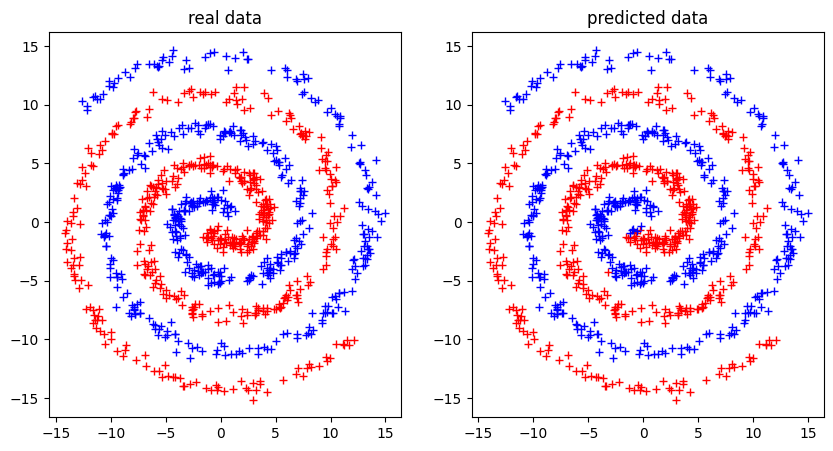

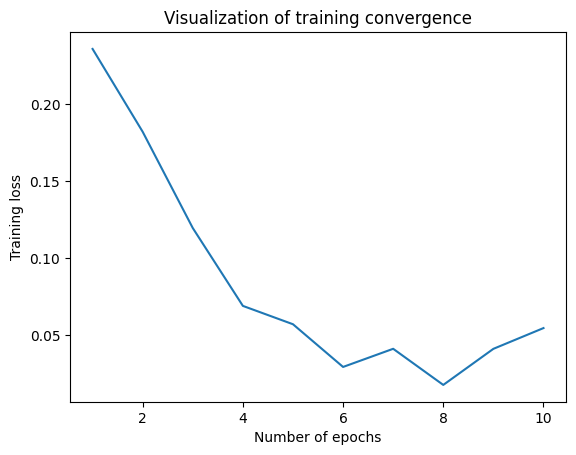

Accuracy on 1000 examples: 99.10%


In [70]:
# Create the model.
model = Model()

# Choose the hyperparameters for the training loop.
num_epochs = 10
batch_size = 16


# Choose the loss function. This one is a mean squared error (MSE) loss, where the
# error refers to the difference between the output of the network and the target label.
loss_function = nn.MSELoss()

# Choose the optimizer. We use a stochastic gradient descent (SGD) optimizer
# with a learning rate (lr) of 0.01.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Run the training loop.
train_losses = train(num_epochs, batch_size, loss_function, optimizer, model, training_set, 1)

#compare predictions
compare_predictions(model)

# Plot the training error w.r.t. the number of epochs.
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.title("Visualization of training convergence")
plt.show()

#accuracy check with diff HPs
print(f"Accuracy on {len(y_val)} examples: {get_accuracy(model):.2%}")


### (Bonus) Exercise: Impact of the loss function

MSELoss is rarely used for classification and instead a cross-entropy loss is used.

Using a cross-entropy loss involves interpreting the output of the network as a probability $p_{model}(y \mid x)$; that is, the probability that the input $x$ belongs to the class $y$ according to the model.

The goal of the neural network can be framed as maximizing the probability of the *correct* class for every datapoint; that is, in maximizing

$$ \prod_{(x,y) \in data} p_{model}(y \mid x) $$

or, equivalently, in minimizing the result of applying $-\log$ to the above:

$$ \sum_{(x,y) \in data} - \log p_{model}(y \mid x) $$

This is called the negative log-likelihood. (For those who have taken statistics courses, minimizing this means that we are doing maximum likelihood estimation.) In our case (where we are doing classification with binary labels), this is mathematically equivalent to the cross-entropy between the true data distribution and the model's predicted distribution, and hence we refer to it as the cross-entropy loss.

(Note that the number of outputs in the final layer of a neural network trained with cross-entropy loss would normally equal the number of possible classes. Because we have a binary problem, it is easier to just have a single output and use [BCELoss](https://pytorch.org/docs/stable/nn.html?highlight=bce#torch.nn.BCELoss).)

Counterintuitively, for numerical stability reasons, it is better to combine the sigmoid (done at the end of the forward function of the model) and the BCELoss into a single function.
This can be done with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html?highlight=bcewithlogit#torch.nn.BCEWithLogitsLoss).

So explicitly, your task is:
- Use `BCEWithLogitsLoss` instead of MSE and see how this changes the behavior in the network. This can also interact with the changes of the previous exercises.
- Ensure you modify your network so there is no sigmoid on the final output.

## Evaluating the model on a test set
### Exercise 3: Prediction on a test set

Once you have chosen your hyperparameters and trained your final model, you should evaluate it on a test dataset (that was never seen during training **or during validation**).

Question: Why is this needed?